<a href="https://colab.research.google.com/github/wolframalexa/FrequentistML/blob/master/gradient_boosted_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Assignment 4: xTreme Gradient Boosted Trees
# Select a dataset for either classification or regression. It can be the same dataset 
# as the one you used in the previous assignments, or a new one. Use an out of the box package 
# for xTreme gradient boosting trees such as https://xgboost.readthedocs.io/en/latest/.
# Use the same 80-10-10 split to tune your classifier/regression method and report your performance and output the feature importance. 
# Do the features reported make sense? If you are using the same dataset from assignment 1 or 2, do they agree with what you discovered using the Lasso penalty?

In [ ]:
#----------IMPORT PACKAGES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse

In [ ]:
#----------READ DATA

data = 'https://raw.githubusercontent.com/wolframalexa/FrequentistML/master/datasets/life_expectancy_data.csv'
dataframe = pd.read_csv(data, sep=',', header='infer')


In [ ]:
#----------CLEAN DATA

# Add column to account for intercept 
ones_col = np.ones(len(dataframe))
dataframe.insert(0, "intercept", ones_col, True) 

# Drop rows with missing data
clean_data = dataframe.dropna(axis=0)

# Rename columns
clean_data.columns = ['intercept','country','year','status','life_exp','adult_mort','infant_mort','alcohol','percent_exp','hep_b','measles','bmi','under_five_mort','polio','tot_exp',
                      'diphtheria','hiv_aids','gdp','population','thin_1-19','thin_5-9','income_comp_res','schooling'] 

# Remove rows with invalid data
clean_data = clean_data[clean_data['infant_mort'] <= 1000] 
clean_data = clean_data[clean_data['measles'] <= 1000] 
clean_data = clean_data[clean_data['under_five_mort'] <= 1000]

# Show data information                    
clean_data.describe()

,intercept,year,life_exp,adult_mort,infant_mort,alcohol,percent_exp,hep_b,measles,bmi,under_five_mort,polio,tot_exp,diphtheria,hiv_aids,gdp,population,thin_1-19,thin_5-9,income_comp_res,schooling
count,1357.0,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.00000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1.357000e+03,1357.000000,1357.000000,1357.000000,1357.000000
mean,1.0,2007.941783,70.062122,161.971997,10.862196,4.720442,780.089679,81.265291,91.20339,40.379366,15.097273,85.208548,6.104576,85.543110,1.941489,6123.079003,7.627781e+06,4.215623,4.258364,0.641920,12.409506
std,0.0,4.041488,8.690290,123.624297,25.177559,4.054261,1883.611933,24.863380,193.88610,19.534123,36.859127,21.512464,2.279412,21.154592,6.180984,12197.905019,2.014408e+07,3.728639,3.802764,0.189328,2.745448
min,1.0,2000.000000,44.000000,1.000000,0.000000,0.010000,0.000000,2.000000,0.00000,2.000000,0.000000,3.000000,0.740000,2.000000,0.100000,5.668726,3.400000e+01,0.100000,0.100000,0.000000,4.200000
25%,1.0,2005.000000,65.200000,74.000000,0.000000,1.070000,40.806180,79.000000,0.00000,22.800000,0.000000,84.000000,4.600000,84.000000,0.100000,519.292285,1.557560e+05,1.500000,1.500000,0.542000,10.700000
50%,1.0,2008.000000,72.300000,144.000000,2.000000,4.040000,179.170133,92.000000,3.00000,46.400000,3.000000,94.000000,5.990000,94.000000,0.100000,1839.729450,1.143896e+06,2.700000,2.800000,0.690000,12.500000
75%,1.0,2011.000000,75.400000,219.000000,11.000000,7.440000,579.133164,96.000000,64.00000,56.700000,13.000000,97.000000,7.610000,97.000000,0.600000,5414.634326,5.737723e+06,6.500000,6.500000,0.762000,14.300000
max,1.0,2015.000000,89.000000,723.000000,549.000000,17.870000,18961.348600,99.000000,999.00000,77.100000,879.000000,99.000000,14.390000,99.000000,50.600000,119172.741800,1.986867e+08,19.700000,19.900000,0.936000,20.700000


In [ ]:
#----------SEPARATE DATA

# Choose seed
np.random.seed(500)

# Separate training and testing data
train_data, validate_data, test_data = np.split(clean_data.sample(frac=1), [int(.8*len(clean_data)), int(.9*len(clean_data))])

# Separate training inputs and outputs
x_train = train_data.drop(['life_exp','country','status'], axis=1)  
y_train = train_data['life_exp']

# Separate validation inputs and outputs
x_validate = validate_data.drop(['life_exp','country','status'], axis=1)  
y_validate = validate_data['life_exp']

# Separate testing inputs and outputs
x_test = test_data.drop(['life_exp','country','status'], axis=1)
y_test = test_data['life_exp']

# Normalize testing validation and training inputs
x_train = (x_train-x_train.min())/(x_train.max()-x_train.min()) 
x_train.intercept = np.ones(len(x_train))
x_validate = (x_validate-x_validate.min())/(x_validate.max()-x_validate.min()) 
x_validate.intercept = np.ones(len(x_validate))
x_test = (x_test-x_test.min())/(x_test.max()-x_test.min()) 
x_test.intercept = np.ones(len(x_test))


In [ ]:
#--------TRAIN MODEL

etas = np.linspace(0,1,10)
depth_lim = 5
estimators_lim = 5


min_score = 100
for depth in range(depth_lim): # nest these to get all possible models
  for estimators in range(estimators_lim):
    for rate in etas:
      # make and fit model with these parameters
      xgb_model = xgb.XGBRegressor(n_estimators = estimators, learning_rate=rate, objective="reg:squarederror", max_depth=depth)
      xgb_model.fit(x_train, y_train)
      y_pred = xgb_model.predict(x_validate)

      # score model and choose model with lowest error
      score = mse(y_validate, y_pred)
      if score < min_score:
        min_score = score
        best_model = xgb_model

print("The best model is the following:\n",best_model)

The best model is the following:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.8888888888888888,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=4, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)


In [ ]:
#--------PREDICT AND REPORT FEATURE IMPORTANCE

y_pred_test = best_model.predict(x_test)
test_score = mse(y_test, y_pred_test)
print("Score on test set:",test_score)
print("Feature importances:\n",list(zip(x_test.columns,xgb_model.feature_importances_)))


Score on test set: 7.424513591207594
Feature importances:
 [('intercept', 0.0), ('year', 0.0018047928), ('adult_mort', 0.025521992), ('infant_mort', 0.006940946), ('alcohol', 0.022453226), ('percent_exp', 0.010459741), ('hep_b', 0.0), ('measles', 0.00012279741), ('bmi', 0.0075482745), ('under_five_mort', 0.065146804), ('polio', 0.0), ('tot_exp', 0.0077739116), ('diphtheria', 0.0), ('hiv_aids', 0.605227), ('gdp', 0.0), ('population', 0.0), ('thin_1-19', 0.0), ('thin_5-9', 0.07071378), ('income_comp_res', 0.15453555), ('schooling', 0.021751178)]


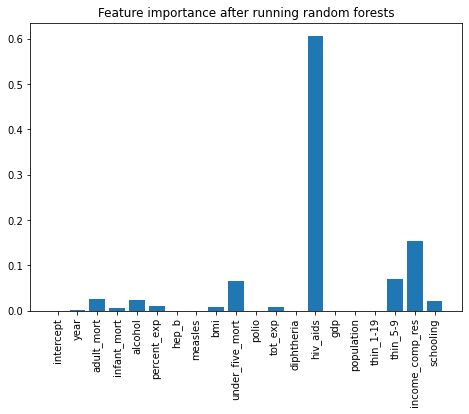

In [ ]:
#----------PLOT FEATURE IMPORTANCE

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white') # necessary bc dark mode
ax = fig.add_axes([0,0,1,1])
features = x_test.columns
importances = xgb_model.feature_importances_
ax.bar(features, importances)
plt.xticks(rotation=90)
plt.title("Feature importance after running random forests")
plt.show()

The most important features are HIV/AIDS, income, adult mortality, alcohol use, the under-five mortality rate, the thinness rate for children 5-9, and schooling. It makes sense that these would have an impact on life expectancy.

This agrees for the most part with the results for project #1 when using Lasso. The intercept and GDP are not important here even though they were included when using the Lasso method, while alcohol usage was included here but not using Lasso. This could be because of correlations between features that results in one being included in Lasso and the other being included when using gradient boosted trees.

XGB returns a score on the test set of 7.4, compared to 12.3 using linear regression - the model is more accurate.